http://cv-tricks.com/tensorflow-tutorial/understanding-alexnet-resnet-squeezenetand-running-on-tensorflow/

In [1]:
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
naosei = cv.imread('../bagunca/DeepLearning-DataScience/data/esperanca.png', 0)

In [3]:
%matplotlib inline

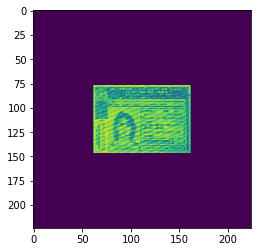

In [4]:
def img_pad(img, downscale):
    downscale = 10+int(8*downscale)
    dimensions = (int(img.shape[1]/downscale), int(img.shape[0]/downscale))
    img_ = cv.resize(img, dimensions)
    pad_to_224_x = int((224 - img_.shape[0])/2)
    pad_to_224_y = int((224 - img_.shape[1])/2)
    img_ = np.pad(img_, ((pad_to_224_x, pad_to_224_x), (pad_to_224_y, pad_to_224_y)), 'constant', constant_values=(0, 0))
    img_ = cv.resize(img_, (224,224))
    return img_
modacaralha = img_pad(naosei, random.random())
plt.imshow(modacaralha)

0.7329029366418819


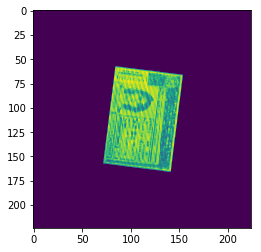

In [5]:
def img_rotate(img, angle):
    num_rows, num_cols = img.shape[:2]
    rotation_matrix = cv.getRotationMatrix2D((num_cols/2, num_rows/2), angle, 1)
    img_rotation = cv.warpAffine(img, rotation_matrix, (num_cols, num_rows))
    return img_rotation

rotation = random.random()
modacaralha = img_rotate(modacaralha, int(rotation*360))
print(rotation)
plt.imshow(modacaralha)

In [6]:
def create_batch(img, size):
    batch_x, batch_y = [], []
    for i in range(size):
        rotation_val = random.random()
        rotated_img = img_rotate(img_pad(naosei, random.random()), int(rotation_val*360))
        batch_x.append(rotated_img.ravel())
        batch_y.append([rotation_val])
    return batch_x, batch_y

In [7]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.nn.relu(tf.matmul(input_layer, W) + b)

In [8]:
from tensorflow.contrib import slim

In [9]:
COLOR_CHANNELS = 1
data_ph = tf.placeholder(tf.float32, shape=[None, COLOR_CHANNELS*224**2])
output_ph = tf.placeholder(tf.float32, shape=[None, 1])
learning_rate = tf.placeholder('float', [])

In [10]:
def alexNet_convolutions(x_image):
    hl = tf.layers.batch_normalization(slim.conv2d(x_image, 32, [11,11], stride=4))
    print(hl.shape)
    hl = slim.max_pool2d(hl, [3,3], stride=2)
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 86, [5,5]))
    print(hl.shape)
    hl = slim.max_pool2d(hl, [3,3], stride=2)
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 128, [3, 3]))
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 128, [3, 3]))
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 86, [3, 3]))
    print(hl.shape)
    hl = slim.max_pool2d(hl, [3,3], stride=2)
    print(hl.shape)
    
    return hl

In [11]:
x_image = tf.reshape(tf.layers.batch_normalization(data_ph), [-1, 224, 224, COLOR_CHANNELS])
hl = alexNet_convolutions(x_image)
hl = slim.flatten(tf.sigmoid(hl))
print(hl.shape)

(?, 56, 56, 32)
(?, 27, 27, 32)
(?, 27, 27, 86)
(?, 13, 13, 86)
(?, 13, 13, 128)
(?, 13, 13, 128)
(?, 13, 13, 86)
(?, 6, 6, 86)
(?, 3096)


In [12]:
fc = slim.stack(hl, slim.fully_connected, [3096, 1569, 564, 84, 1])
print(fc.shape)

(?, 1)


In [13]:
loss = tf.reduce_mean((fc - output_ph)**2)
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [14]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
%matplotlib notebook
import time

batch_size = 3
steps = 500000
rate = 3e-8

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = create_batch(naosei, batch_size)
        feed = {data_ph:batch_x, output_ph:batch_y, learning_rate:rate}
        sess.run(train, feed_dict=feed)
        
        if i%100 == 0:
            if i > 1000:
                rate = 3e-6
            if i > 250000:
                rate = 3e-8
            if i > 450000:
                rate = 3e-9
            print('Step:', i)
            last_loss = sess.run(loss, feed_dict = feed)
            print(last_loss)
            pred = sess.run(fc, feed_dict={data_ph:[modacaralha.ravel()]})
            print(pred)
            ax.clear()
            ax.imshow(img_rotate(modacaralha, -360*pred))
            fig.canvas.draw()
            test_batch, _ = create_batch(naosei, 10)
            final_pred = sess.run(fc, feed_dict={data_ph:test_batch})
    location = "./saved_models/unrotate2/unrotate.ckpt"
    save_path = saver.save(sess, location)
    print("model saved in ", location)

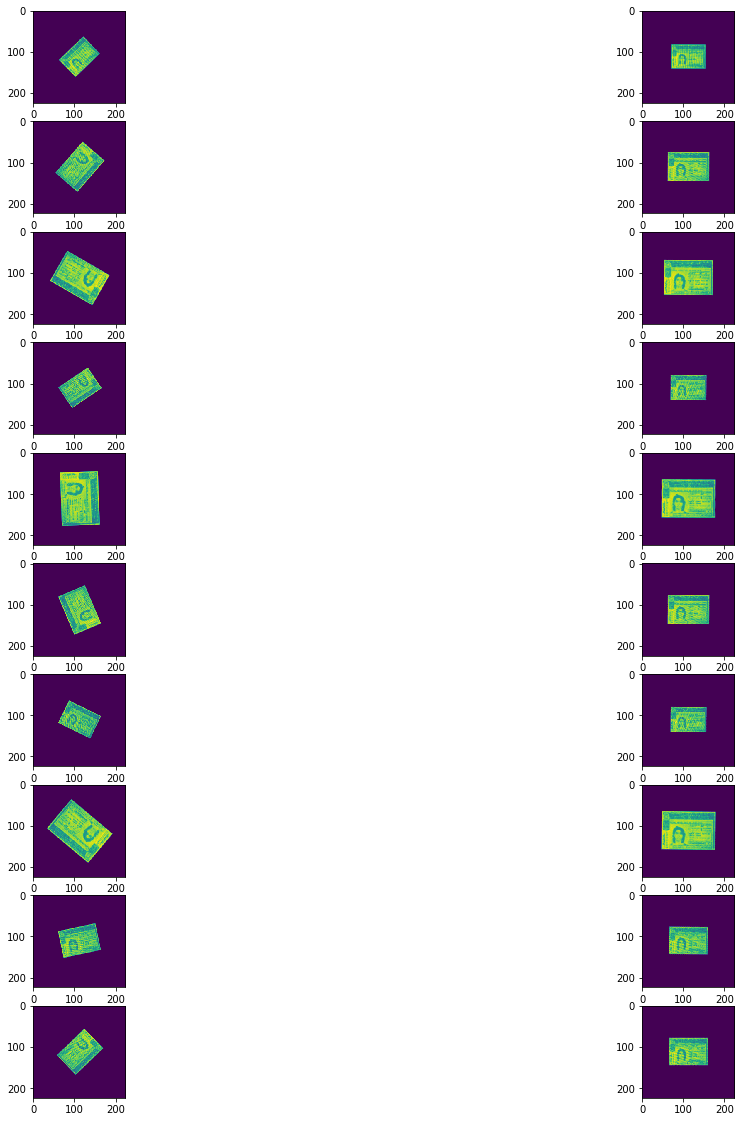

In [18]:
%matplotlib inline
plots = []
fig = plt.figure(figsize=(20,20))
__=0
for i in range(len(final_pred)):
    plots.append(fig.add_subplot(10, 2, __+1))
    plots[__].imshow(test_batch[i].reshape(224,224))
    plots.append(fig.add_subplot(10, 2, __+2))
    plots[__+1].imshow(img_rotate(test_batch[i].reshape(224, 224), -360*final_pred[i]))
    __ += 2
    